<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/MobileSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileSAM:　軽量な基盤モデルによるセグメンテーション
通常、画像セグメンテーションのための基盤モデルは非常に大規模で重たいものが多く、モバイルデバイスなどのリソースが限られた環境での実行は困難です。ここで紹介するMobileSAMは、Meta社が開発した基盤モデルSegment Everything Model (SAM)の性能を維持しつつ、様々な改善点を導入することで、わずか9.66Mのパラメータで12ミリ秒の処理時間を実現しています。これは、基盤モデルの大幅な軽量化と高速化を意味します。今回はMobileSAMを使って画像中の全ての物体を検出し、その領域を切り出してみましょう。

## ライセンス
- MobileSAMレポジトリ
    - https://github.com/ChaoningZhang/MobileSAM
    - Apache-2.0
- ぶどうサンプル画像
    - https://ja.wikipedia.org/wiki/%E3%83%96%E3%83%89%E3%82%A6#/media/%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB:Marufuji_Winery_190907f1.jpg
    - CC-BY-SA-4.0
- 本ノートブック
    - CC-BY-NC-4.0

## 環境設定

In [ ]:
# MobileSAMのインストール
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# MobileSAM重みファイルのダウンロード
!wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt

# サンプル画像のダウンロード
!wget -O grape.jpg https://upload.wikimedia.org/wikipedia/commons/5/54/Marufuji_Winery_190907f1.jpg

In [17]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## 解析対象画像の確認

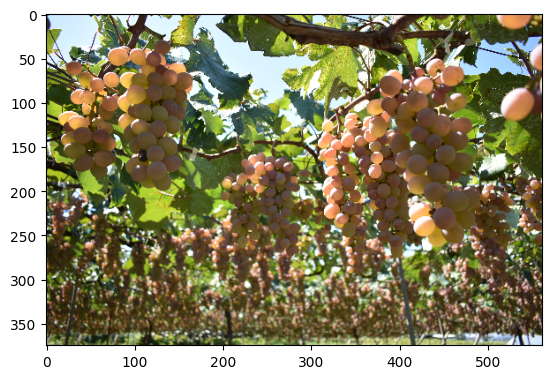

In [32]:
path = "grape.jpg"
image = cv2.imread(path)[...,::-1]
image = cv2.resize(image, dsize=None, fx=1/8, fy=1/8)
plt.imshow(image)

## 推論

モデルを準備します。

In [2]:
model_type = "vit_t"
sam_checkpoint = "mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()
mask_generator = SamAutomaticMaskGenerator(mobile_sam)

/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_

推論します。

In [33]:
masks = mask_generator.generate(image)

## 結果確認

In [34]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

(0.0, 562.0, 375.0, 0.0)

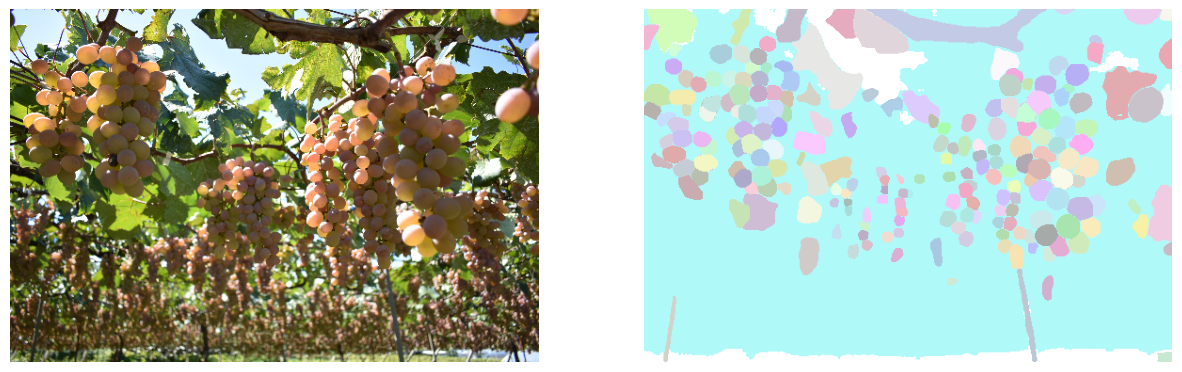

In [40]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1,2,2)
show_anns(masks)
plt.xlim([0,image.shape[1]])
plt.ylim([image.shape[0], 0])
plt.axis('off')

## 推論結果の変数解説

ネットワーク推論から得られる変数masksは辞書を要素とするリスト型です。今回の場合、検出された物体218個分となります。それぞれの辞書にはマスク画像やbbox座標などが格納されています。

In [48]:
print(type(masks))
print(len(masks))
print(type(masks[0]))
print(masks[0].keys())
print("___")
pprint(masks[0])

<class 'list'>
218
<class 'dict'>
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
___
{'area': 198024,
 'bbox': [0, 0, 561, 372],
 'crop_box': [0, 0, 562, 375],
 'point_coords': [[149.28125, 240.234375]],
 'predicted_iou': 1.0120505094528198,
 'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
 'stability_score': 0.9574075937271118}


単一領域のみ、マスク領域を描画してみましょう。

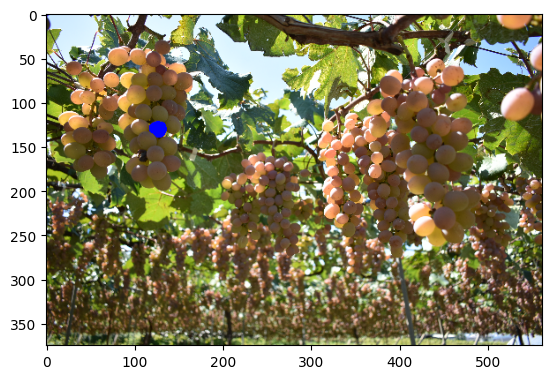

In [61]:
image2 = image.copy()
mask = masks[10]
contours, _ = cv2.findContours(mask["segmentation"].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image2, contours, -1, (0, 0, 255), thickness=cv2.FILLED)
plt.imshow(image2)